Load data set

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')
 

In [59]:
%pip install openpyxl

csv_path = r"C:\OTHER PARTITIONS\Partition D\ADA - Degree Program\DA 2015 - Statistical Laboratory II - Group Presentation\Data Set\Final data set-Global Air Pollution (2025-11-08).csv"
try:
	df = pd.read_csv(csv_path, encoding='utf-8')
except UnicodeDecodeError:
	df = pd.read_csv(csv_path, encoding='latin-1')
df.head()

Note: you may need to restart the kernel to use updated packages.


,Burden Id,Type,Country,ISO3,Region,Name,Year,Measure,Metric,Sex,...,Age Group Name,Burden Mean,Burden Mean Rounded,Burden Upper,Burden Lower,Pollutant,Pollutant Name,Region Name,Measure Name,Metric Name
0,212,country,Armenia,ARM,superReg,"Central Europe, Eastern Europe, and Central Asia",1990,death,number,Both,...,All Ages,"2,610","2,610","4,300","1,180",PM2.5,PM2.5,GBD Super Regions,Death,Number
1,220,country,Armenia,ARM,superReg,"Central Europe, Eastern Europe, and Central Asia",1991,death,number,Both,...,All Ages,"2,680","2,680","4,290","1,480",PM2.5,PM2.5,GBD Super Regions,Death,Number
2,228,country,Armenia,ARM,superReg,"Central Europe, Eastern Europe, and Central Asia",1992,death,number,Both,...,All Ages,"2,740","2,740","4,310","1,640",PM2.5,PM2.5,GBD Super Regions,Death,Number
3,236,country,Armenia,ARM,superReg,"Central Europe, Eastern Europe, and Central Asia",1993,death,number,Both,...,All Ages,"2,710","2,710","4,360","1,600",PM2.5,PM2.5,GBD Super Regions,Death,Number
4,244,country,Armenia,ARM,superReg,"Central Europe, Eastern Europe, and Central Asia",1994,death,number,Both,...,All Ages,"2,540","2,540","4,040","1,380",PM2.5,PM2.5,GBD Super Regions,Death,Number


In [60]:
df.tail()

,Burden Id,Type,Country,ISO3,Region,Name,Year,Measure,Metric,Sex,...,Age Group Name,Burden Mean,Burden Mean Rounded,Burden Upper,Burden Lower,Pollutant,Pollutant Name,Region Name,Measure Name,Metric Name
19599,1152166,country,Sudan,SDN,superReg,North Africa and Middle East,2019,daly,number,Both,...,All Ages,"1,231,000","1,231,000","1,492,000","983,300",airpoll,Air Pollution,GBD Super Regions,DALY,Number
19600,1152175,country,Sudan,SDN,superReg,North Africa and Middle East,2020,daly,number,Both,...,All Ages,"1,200,000","1,200,000","1,435,000","950,400",airpoll,Air Pollution,GBD Super Regions,DALY,Number
19601,1152184,country,Sudan,SDN,superReg,North Africa and Middle East,2021,daly,number,Both,...,All Ages,"1,189,000","1,189,000","1,417,000","957,400",airpoll,Air Pollution,GBD Super Regions,DALY,Number
19602,1152193,country,Sudan,SDN,superReg,North Africa and Middle East,2022,daly,number,Both,...,All Ages,"1,187,000","1,187,000","1,413,000","945,900",airpoll,Air Pollution,GBD Super Regions,DALY,Number
19603,1152202,country,Sudan,SDN,superReg,North Africa and Middle East,2023,daly,number,Both,...,All Ages,"1,172,000","1,172,000","1,402,000","941,100",airpoll,Air Pollution,GBD Super Regions,DALY,Number


In [65]:
# Normalize column names by stripping whitespace (handles cases where columns were already renamed)
df.columns = df.columns.str.strip()

# List of burden columns (after stripping spaces from names)
cleaned_burden_cols = ['Burden Mean', 'Burden Mean Rounded', 'Burden Upper', 'Burden Lower']

# 1. Clean and convert columns to numeric, replacing non-numeric entries with NaN
for col in cleaned_burden_cols:
    if col in df.columns:
        # Remove commas and use errors='coerce' to turn non-numeric values into NaN
        df[col] = df[col].astype(str).str.replace(',', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        # If a column is missing, warn but continue (prevents KeyError)
        print(f"Warning: column '{col}' not found in dataframe. Skipping conversion for this column.")

# 2. Remove rows with NaN in the available specified columns
available_cols = [c for c in cleaned_burden_cols if c in df.columns]
if available_cols:
    df_cleaned = df.dropna(subset=available_cols)
else:
    # If none of the expected columns exist, keep original df and warn
    df_cleaned = df.copy()
    print("Warning: none of the expected burden columns were found; no rows were dropped.")

# Display results
print(f"Initial number of rows: {df.shape[0]}")
print(f"Number of rows after removing missing burden entries: {df_cleaned.shape[0]}")
print(f"Number of rows removed: {df.shape[0] - df_cleaned.shape[0]}")

Initial number of rows: 19604
Number of rows after removing missing burden entries: 19409
Number of rows removed: 195


In [66]:
# 01. Summary Statistics

print("--- Summary Statistics of Burden Mean (by Measure - Death and DALY) ---")
burden_stats = df.groupby('Measure')['Burden Mean'].describe().transpose()
print(burden_stats)

--- Summary Statistics of Burden Mean (by Measure - Death and DALY) ---
Measure          daly         death
count    8.112000e+03  1.140200e+04
mean     7.774689e+05  3.059001e+04
std      3.802926e+06  1.641227e+05
min      4.000000e+00  1.000000e+00
25%      1.720000e+04  5.582500e+02
50%      7.930000e+04  3.100000e+03
75%      3.587250e+05  1.400000e+04
max      6.301000e+07  2.333000e+06


Generated Plots:
global_burden_trend_PM2.5_death.png
global_burden_trend_PM2.5_daly.png
global_burden_trend_Air_Pollution_death.png
global_burden_trend_Air_Pollution_daly.png

Summary of Trends (Burden Mean in Millions):
--- PM2.5 - death ---
1990 Burden: 2.10M
2023 Burden: 4.58M
--- PM2.5 - daly ---
1990 Burden: 75.05M
2023 Burden: 117.12M
--- Air Pollution - death ---
1990 Burden: 6.58M
2023 Burden: 7.54M
--- Air Pollution - daly ---
1990 Burden: 240.22M
2023 Burden: 225.64M


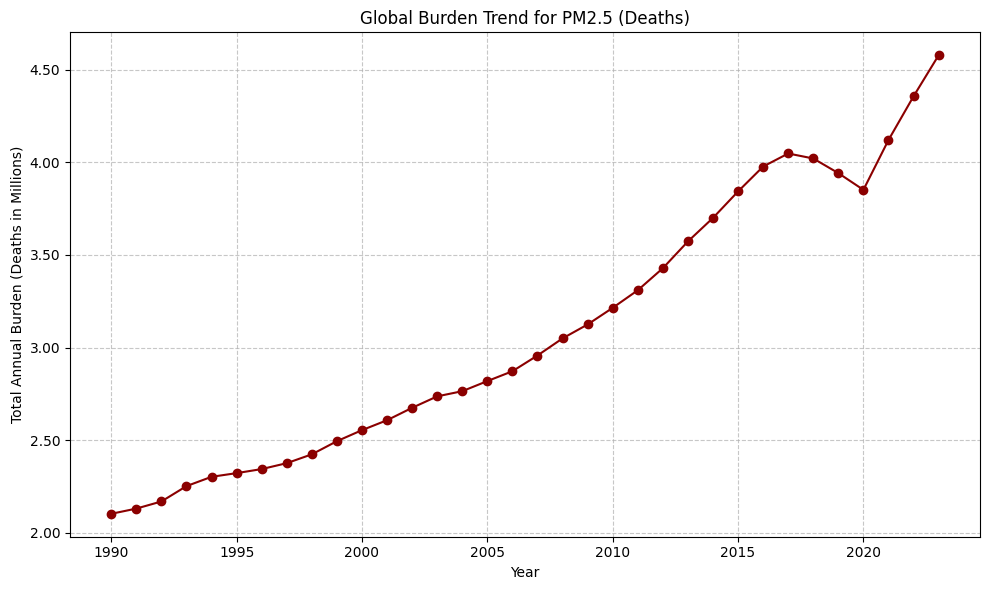

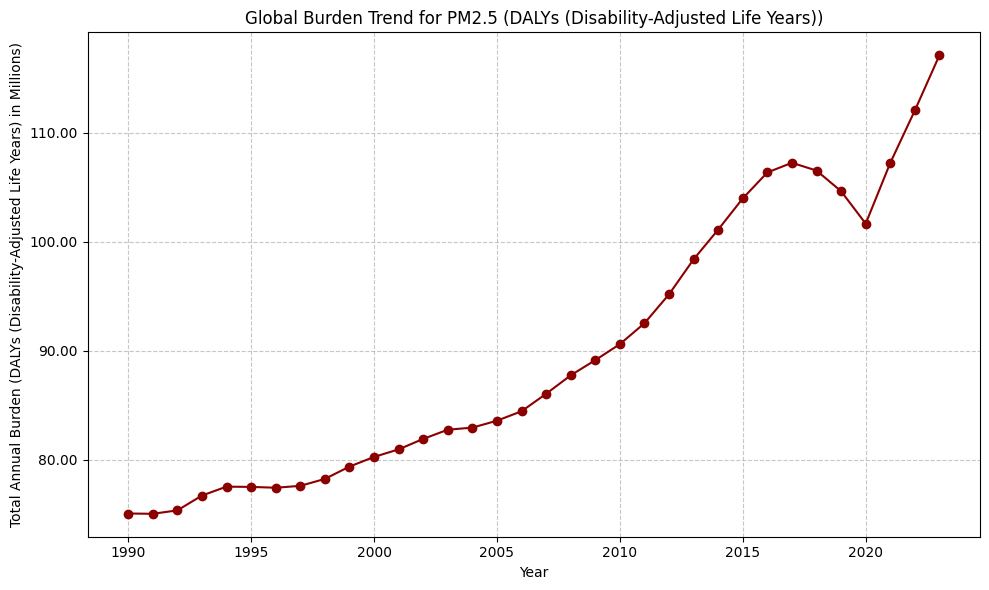

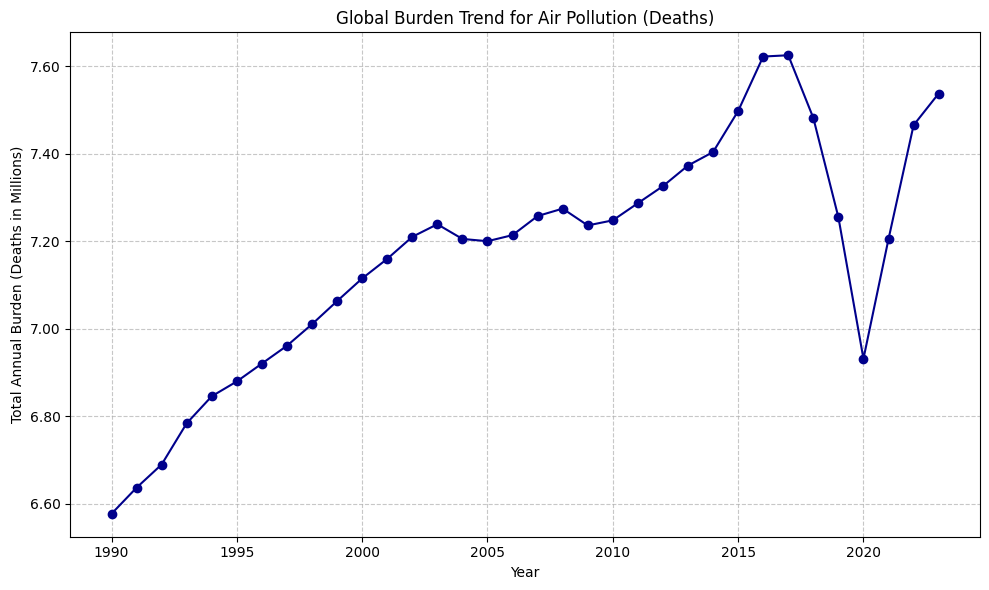

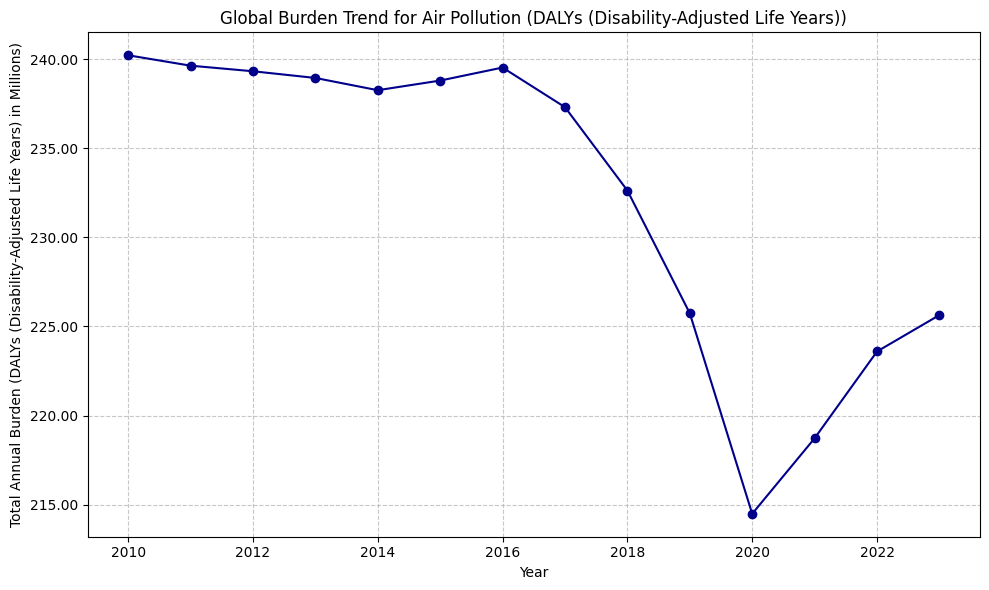

In [68]:
# List of burden columns to clean (as previously identified)
burden_cols_with_spaces = ['  Burden Mean  ', '  Burden Mean Rounded  ', '  Burden Upper  ', '  Burden Lower  ']
cleaned_burden_cols = ['Burden Mean', 'Burden Mean Rounded', 'Burden Upper', 'Burden Lower']

# Clean and convert columns to numeric
for col in burden_cols_with_spaces:
    new_col_name = col.strip()
    df.rename(columns={col: new_col_name}, inplace=True)
    
    # Remove commas and use errors='coerce' to turn non-numeric values into NaN
    df[new_col_name] = df[new_col_name].astype(str).str.replace(',', '', regex=False)
    df[new_col_name] = pd.to_numeric(df[new_col_name], errors='coerce')

# Remove rows with NaN in the specified columns (which were none in the previous check, but good practice)
df_clean = df.dropna(subset=cleaned_burden_cols)

# --- 2. Calculate Global Trends ---
global_trend = df_clean.groupby(['Year', 'Pollutant Name', 'Measure'])['Burden Mean'].sum()

# --- 3. Define Plotting Parameters ---
pollutants = ['PM2.5', 'Air Pollution']
measures = ['death', 'daly']
titles = {
    'death': 'Deaths',
    'daly': 'DALYs (Disability-Adjusted Life Years)'
}
colors = {
    'PM2.5': 'darkred',
    'Air Pollution': 'darkblue'
}

# --- 4. Generate Plots ---
plot_filenames = []
summary_data = {}

def plot_trend(pollutant, measure):
    """Filters data and plots the trend for a specific pollutant and measure."""
    
    # Filter the series
    series = global_trend.loc[:, pollutant, measure]
    
    # Check if data exists for the combination
    if series.empty:
        print(f"No data found for {pollutant} - {measure}.")
        return

    # Store first and last year data for summary
    summary_data[f'{pollutant} - {measure}'] = {
        '1990': series.iloc[0],
        '2023': series.iloc[-1]
    }

    plt.figure(figsize=(10, 6))
    
    # Plot the series
    plt.plot(series.index, series.values, 
             label=f'Global {titles[measure]} Burden', 
             color=colors[pollutant], 
             marker='o', 
             linestyle='-')

    # Formatting
    title = f'Global Burden Trend for {pollutant} ({titles[measure]})'
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel(f'Total Annual Burden ({titles[measure]} in Millions)')
    
    # Convert y-axis labels to millions
    formatter = plt.FuncFormatter(lambda x, pos: f'{x/1e6:.2f}')
    plt.gca().yaxis.set_major_formatter(formatter)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save file
    filename = f'global_burden_trend_{pollutant.replace(" ", "_")}_{measure}.png'
    plt.savefig(filename)
    plot_filenames.append(filename)

# Execute plotting for all four combinations
for pollutant in pollutants:
    for measure in measures:
        plot_trend(pollutant, measure)

print("Generated Plots:")
for filename in plot_filenames:
    print(filename)
    
print("\nSummary of Trends (Burden Mean in Millions):")
for key, values in summary_data.items():
    print(f"--- {key} ---")
    # Convert to millions for display
    start_burden = values['1990'] / 1e6 if not pd.isna(values['1990']) else 'N/A'
    end_burden = values['2023'] / 1e6 if not pd.isna(values['2023']) else 'N/A'
    
    print(f"1990 Burden: {start_burden:.2f}M")
    print(f"2023 Burden: {end_burden:.2f}M")

In [71]:
#03. Geographical Distribution Analysis (Year 2023)
df_2023 = df[df['Year'] == 2023]
country_burden_2023 = df_2023.groupby(['Country', 'Measure'])['Burden Mean'].sum().unstack()
print(country_burden_2023.head())

Measure              daly    death
Country                           
Afghanistan     1645300.0  33900.0
Albania           81200.0   4160.0
Algeria         1148700.0  40300.0
American Samoa      617.0     20.0
Angola          1319100.0  25030.0


In [72]:
# Top 10 Countries by Death Burden in 2023
top_10_deaths = country_burden_2023.sort_values(by='death', ascending=False).head(10)['death']
print("\n_Top 10 Countries by Air Pollution Deaths in 2023_")
print(top_10_deaths)

# Top 10 Countries by DALY Burden in 2023
top_10_dalys = country_burden_2023.sort_values(by='daly', ascending=False).head(10)['daly']
print("\n_Top 10 Countries by Air Pollution DALYs in 2023_")
print(top_10_dalys)


_Top 10 Countries by Air Pollution Deaths in 2023_
Country
China                 3841000.0
India                 2975700.0
Pakistan               347000.0
Indonesia              339200.0
Bangladesh             334600.0
Nigeria                287400.0
Egypt                  224400.0
Russian Federation     181400.0
Brazil                 165400.0
Myanmar                162400.0
Name: death, dtype: float64

_Top 10 Countries by Air Pollution DALYs in 2023_
Country
India                               86530000.0
China                               78060000.0
Nigeria                             16354000.0
Pakistan                            14271000.0
Indonesia                           11098000.0
Bangladesh                           9866000.0
Egypt                                6621000.0
Ethiopia                             5037200.0
Myanmar                              4816000.0
Democratic Republic of the Congo     4649100.0
Name: daly, dtype: float64


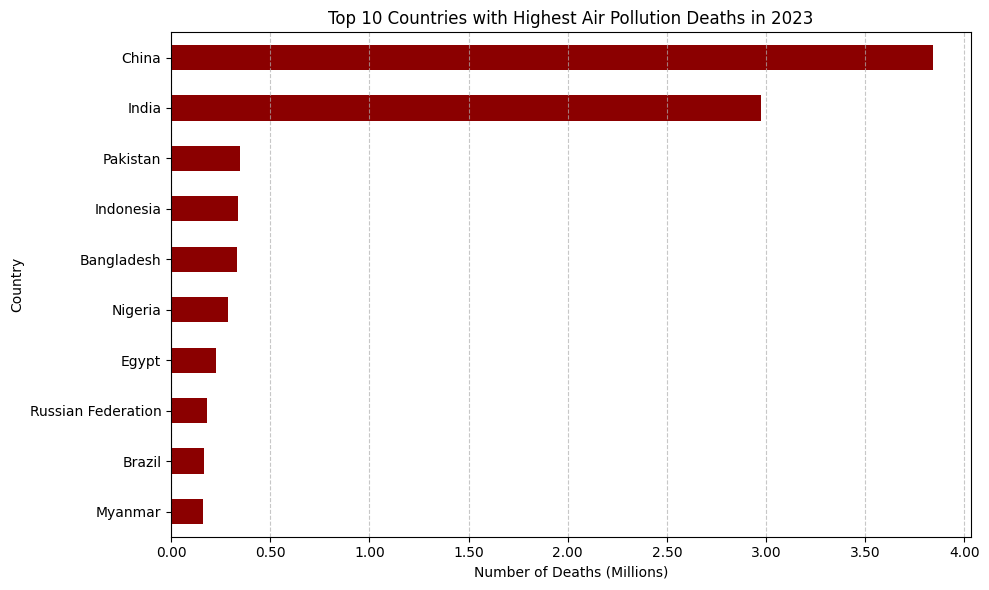

In [73]:
# Plotting the Top 10 Countries (Deaths)

plt.figure(figsize=(10, 6))
top_10_deaths.sort_values(ascending=True).plot(kind='barh', color='darkred')
plt.title('Top 10 Countries with Highest Air Pollution Deaths in 2023')
plt.xlabel('Number of Deaths (Millions)')
plt.ylabel('Country')
formatter = plt.FuncFormatter(lambda x, pos: f'{x/1e6:.2f}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('top_10_deaths_2023.png')

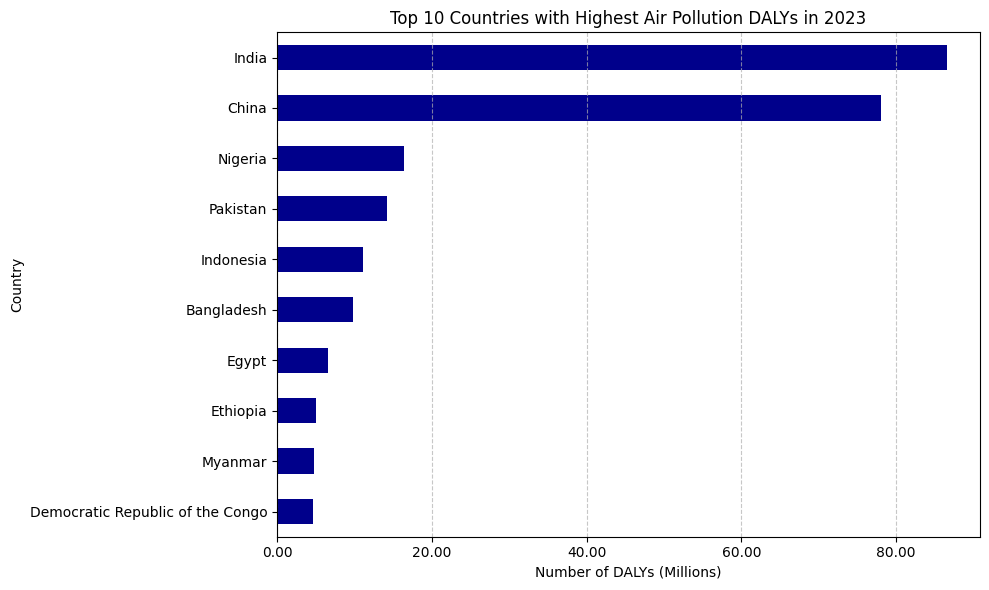

In [74]:
# Plotting the Top 10 Countries (DALYs)

plt.figure(figsize=(10, 6))
top_10_dalys.sort_values(ascending=True).plot(kind='barh', color='darkblue')
plt.title('Top 10 Countries with Highest Air Pollution DALYs in 2023')
plt.xlabel('Number of DALYs (Millions)')
plt.ylabel('Country')
formatter = plt.FuncFormatter(lambda x, pos: f'{x/1e6:.2f}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('top_10_dalys_2023.png')

## DALY to Death Ratio - Analysis ##

Top 10 Countries with the Highest Average DALY-to-Death Ratio (Air Pollution, 2010-2023):
Country
Tokelau                           inf
Niue                              inf
Niger                       67.646374
Somalia                     64.852985
Mali                        64.328860
Central African Republic    62.583337
Nigeria                     61.814936
Chad                        60.859722
Burundi                     60.240356
Côte d'Ivoire               59.937167
Name: DALY_to_Death_Ratio, dtype: float64

Top 10 Countries with the Lowest Average DALY-to-Death Ratio (Air Pollution, 2010-2023):
Country
Hungary      20.021734
Ukraine      19.845494
Romania      19.823569
Slovenia     19.708175
Serbia       19.630644
Estonia      19.416699
Czechia      19.225106
Croatia      19.059623
Latvia       18.785038
Lithuania    18.456782
Name: DALY_to_Death_Ratio, dtype: float64


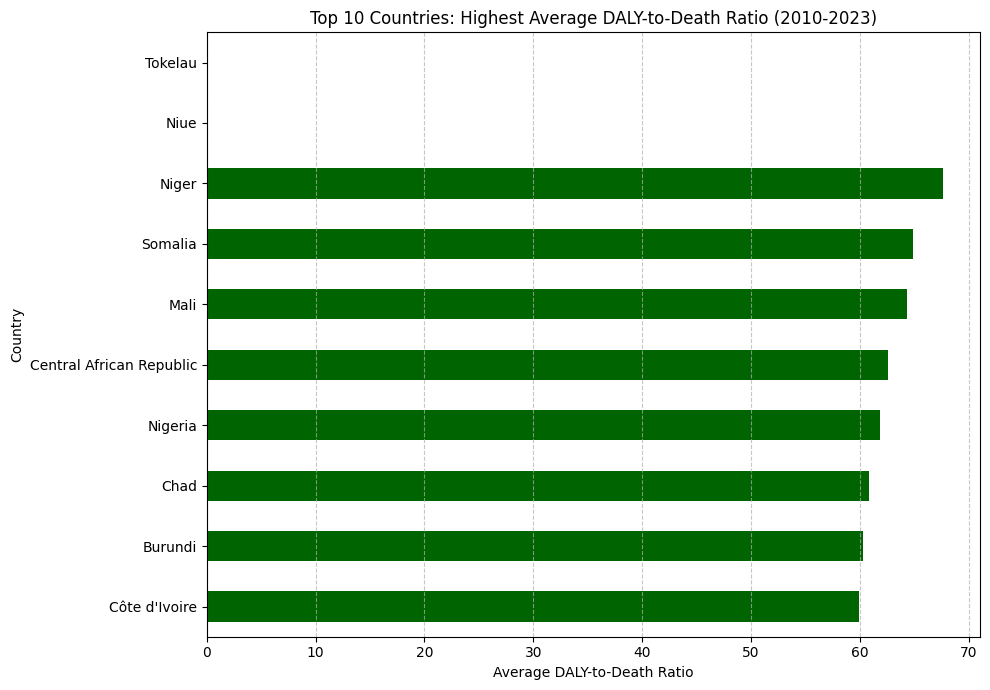

In [75]:

#Comparative Analysis (DALY-to-Death Ratio)

# 1. Filter for total 'Air Pollution' burden (as DALY data for PM2.5 was sparse)
df_ap = df[df['Pollutant Name'] == 'Air Pollution']

# 2. Pivot the data to get 'death' and 'daly' as columns
# Index: Country, Year (The DALY-to-Death ratio must be calculated year-by-year, country-by-country)
burden_pivot = df_ap.pivot_table(
    index=['Country', 'Year'],
    columns='Measure',
    values='Burden Mean',
    aggfunc='sum'
).reset_index()

# Drop rows where either 'daly' or 'death' is missing (DALY data starts in 2010)
burden_pivot.dropna(subset=['daly', 'death'], inplace=True)

# 3. Calculate the DALY-to-Death Ratio
burden_pivot['DALY_to_Death_Ratio'] = burden_pivot['daly'] / burden_pivot['death']

# 4. Analyze the Ratio: Calculate the average ratio per country (2010-2023)
country_ratio_avg = burden_pivot.groupby('Country')['DALY_to_Death_Ratio'].mean().sort_values(ascending=False)

# Top 10 countries with the Highest DALY-to-Death Ratio
top_10_highest_ratio = country_ratio_avg.head(10)

# Top 10 countries with the Lowest DALY-to-Death Ratio
top_10_lowest_ratio = country_ratio_avg.tail(10)

print("Top 10 Countries with the Highest Average DALY-to-Death Ratio (Air Pollution, 2010-2023):")
print(top_10_highest_ratio)

print("\nTop 10 Countries with the Lowest Average DALY-to-Death Ratio (Air Pollution, 2010-2023):")
print(top_10_lowest_ratio)

# 5. Plot the Top 10 Highest Ratio Countries
plt.figure(figsize=(10, 7))
top_10_highest_ratio.sort_values(ascending=True).plot(kind='barh', color='darkgreen')

plt.title('Top 10 Countries: Highest Average DALY-to-Death Ratio (2010-2023)')
plt.xlabel('Average DALY-to-Death Ratio')
plt.ylabel('Country')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('top_10_daly_to_death_ratio.png')

Interpretation: This ratio represents the average number of DALYs lost per death due to air pollution.

A high ratio suggests that the disease burden is disproportionately affecting younger populations (resulting in more Years of Life Lost, or YLL), or that a large part of the burden is due to chronic disability (Years Lived with Disability, or YLD). This is common in low-income settings with high fertility rates and high exposure to risks like household air pollution.

A low ratio suggests the burden is more concentrated in older populations.

Global Average DALY-to-Death Ratio Trend (Air Pollution)
The plot below shows the average ratio across all countries from 2010 to 2023.

Global Average DALY-to-Death Ratio Trend (Air Pollution)
Trend: The global average DALY-to-Death Ratio has shown a consistent declining trend, dropping from approximately 36.9 in 2010 to 33.6 in 2023.

Interpretation: This decline suggests that, on average, air pollution-related deaths are occurring at slightly older ages globally, or that the relative contribution of disability (YLD) to the total burden is decreasing compared to mortality (YLL). This may be reflective of general improvements in life expectancy and healthcare.

##Key Insight:## 
The top 10 list is entirely dominated by countries in Sub-Saharan Africa. This finding is highly significant: it indicates that the air pollution burden in these countries is having a profoundly severe impact by causing disease and premature death in very young populations. For instance, in Niger, for every death, there are nearly 68 DALYs lost.